<a href="https://colab.research.google.com/gist/jonghank/89e4e69bc4207f60ad56044b316c2066/ase2010-applied-linear-algebra-minimum_energy_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__<div style="text-align: right"> ASE2010: Applied linear algebra, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_

<br>

A discrete-time linear dynamical system consists of a sequence of state vectors $x_t \in \R^n$, indexed by time $t\in \{0,\dots,N-1\}$ and dynamics equations

$$
\begin{aligned}
  x_{t+1} &= Ax_t + Bu_t
\end{aligned}
$$

where $u_t\in\R^m$ is a control input to the dynamical system (say, a drive force or steering force on the vehicle). $A$ is the state transition matrix, $B$ is the input matrix.

Given $A$ and $B$, the goal is to find the optimal $u_0, \dots, u_{N-1}$ that drives the systems state to the desirable state at the final time, $x_N= x_\text{des}$, while minimizing the size of $u_0, \dots, u_N$.

<br>

A minimum energy controller finds $u_t$ by solving the following optimization problem

$$
\begin{aligned}
  \underset{u}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|^2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1
\end{aligned}
$$



<br>

We'll apply a minimum energy control to a vehicle guidance problem with state $x_t\in\R^4$, where the first two states are the position of the vehicle in two dimensions, and the last two are the vehicle velocity. The vehicle's control force $u_t\in\R^2$ is acceleration control for the two axes.

<br>

The dynamics for each coordinate is governed by

$$
\begin{aligned}
  \dot{v} &= u - \gamma v  \\
  \dot{p} &= v  
\end{aligned}
$$

where $v$ and $p$ are the velocity and the position along the coordinate, and
a small constant $\gamma$ is the friction (or damping) coefficient. Trapezoidal integration assuming constant acceleration during the sampling interval gives,

$$
\begin{aligned}
  v_{t+1} &= v_t + {\Delta t}\left( u_t - \gamma v_t  \right) \\
  &= \left(1-\gamma \Delta t\right) v_t + \Delta t u_t \\
  p_{t+1} &= p_t + \frac{\Delta t}{2}\left( v_t + v_{t+1} \right)  \\
  &= p_t + \frac{\Delta t}{2}\left( v_t + \left(1-\gamma \Delta t\right) v_t + \Delta t u_t \right)  \\
  &= p_t +  \left(\Delta t-\frac{1}{2}\gamma\Delta t^2\right) v_t + \frac{1}{2} \Delta t^2 u_t
\end{aligned}
$$

Then the above dynamics can be coded into the following:

$$
\begin{aligned}
  x_{t+1} &= Ax_t + Bu_t
\end{aligned}
$$

with the state variable $x_t = (p_{x,t}, p_{y,t}, v_{x,t}, v_{y,t})$. In other words,

$$
\bmat{p_x \\ p_y \\ v_x \\ v_y}_{t+1} = \underbrace{\bmat{
1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t & 0 \\
0 & 1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t \\
0 & 0 & 1-\gamma\Delta t & 0 \\
0 & 0 & 0 & 1-\gamma\Delta t
}}_{A} \bmat{p_x \\ p_y \\ v_x \\ v_y}_t + \underbrace{\bmat{
0.5\Delta t^2 & 0 \\
0 & 0.5\Delta t^2 \\
\Delta t & 0 \\
0 & \Delta t
}}_{B} \bmat{u_x \\ u_y}_t
$$

We consider the finite horizon of $T=50$, with $\Delta t=0.05$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))
C = np.zeros((2,4))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt


<br>

Now we will transform the minimum energy control problem to the standard least norm problem. Note the following relations.

$$
\begin{aligned}
  x_1 &= Ax_0 + Bu_0 \\
  x_2 &= Ax_1 + Bu_1 \\
  &= A(Ax_0 + Bu_0) + Bu_1 \\
  &= A^2 x_0 + AB u_0 + Bu_1 \\
  x_3 &= Ax_2 + Bu_2 \\
  &= A(Ax_1 + Bu_1) + Bu_2 \\
  &= A^2x_1 + AB u_1 + Bu_2 \\
  &= A^2(Ax_0+Bu_0) + AB u_1 + Bu_2 \\
  &= A^3x_0 + A^2Bu_0 + ABu_1 + Bu_2  
\end{aligned}
$$

and in general
$$
x_t = A^tx_0 + \bmat{A^{t-1}B & A^{t-2}B & \cdots & AB & B}
\bmat{u_0 \\u_1 \\ \vdots \\ u_{t-2} \\ u_{t-1}}
$$

which implies that $x_t$ is affine function of $u_0, \dots, u_{t-1}$.

<br>

For the terminal condition at $t=N$, we have

$$
x_N
=  A^Nx_0 +
\underbrace{
\bmat{A^{N-1}B & A^{N-2}B & \cdots & AB & B}
}_{G}
\bmat{u_0 \\u_1 \\ \vdots \\ u_{N-2} \\ u_{N-1}}
$$

which we simply say
$$
x_N = A^Nx_0 + Gu
$$
with $u=(u_0, \dots, u_{N-1})$.

<br>

Now the minimum energy control problem is

$$
\begin{aligned}
  \underset{u}{\minimize} \quad & \|u\|^2 \\
  \text{subject to} \quad & Gu = x_\text{des}-A^Nx_0
\end{aligned}
$$

This is just a simple least norm problem.

Note that you can find the optimal control for any $x_\text{des}$ as long as the rows of $G$ is linearly independent, which is also known as the _controllability condition_ in control theory.


In [2]:
x_0 = np.array([10, -20, 15, -5])
x_des = np.array([100, 50, 0, 0])

G = np.zeros((4,2*N))

for i in range(N):
  G[:, 2*i:2*(i+1)] = np.linalg.matrix_power(A,max(0,N-i-1))@B

u_hat = np.linalg.lstsq(G,x_des - np.linalg.matrix_power(A,N)@x_0, rcond=0)[0]

In [3]:
u_vec = u_hat

u_opt = u_vec.reshape(1000,2).T

x = np.zeros((4,N+1))
x[:,0] = x_0

for t in range(N):
    x[:,t+1] = A.dot(x[:,t]) + B.dot(u_opt[:,t])

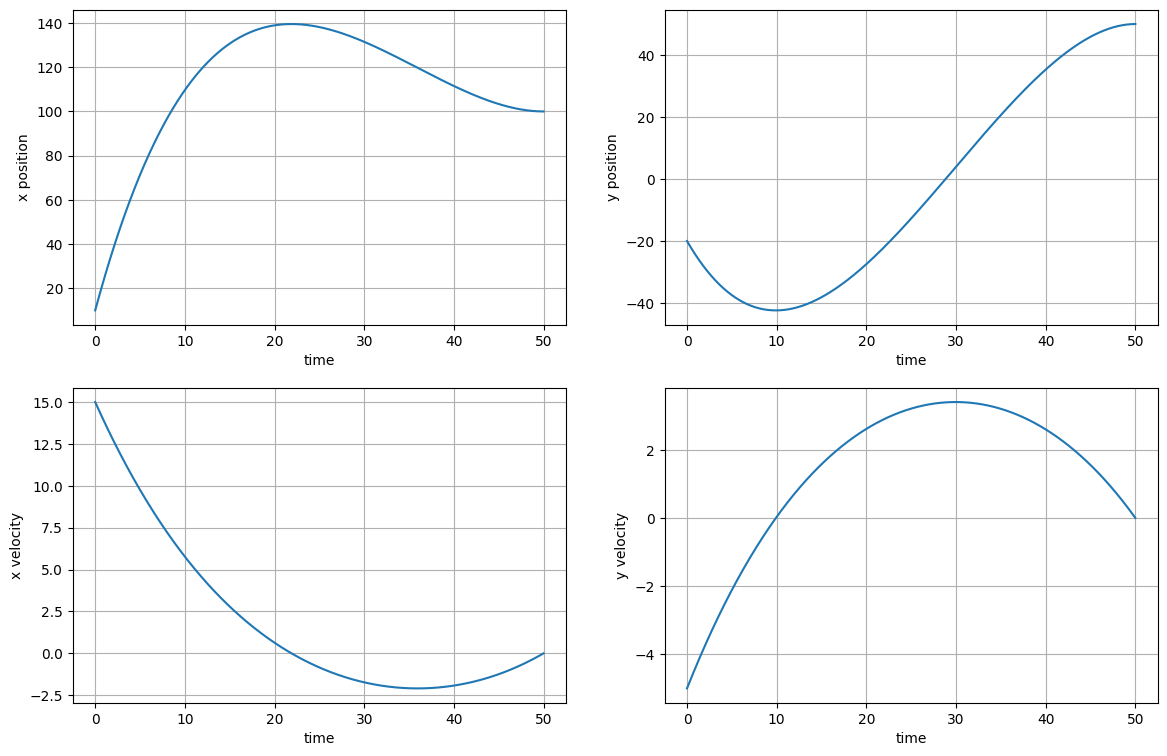

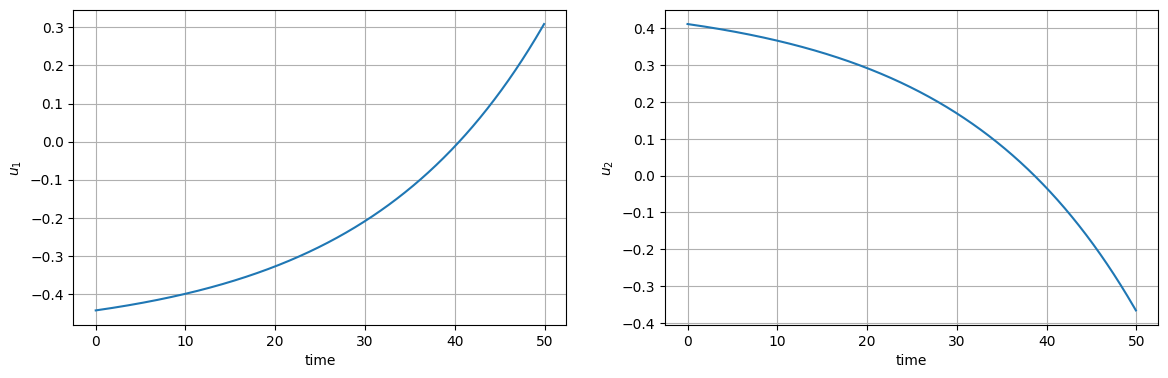

In [4]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x[0,:])
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x[1,:])
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x[2,:])
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:])
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:])
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

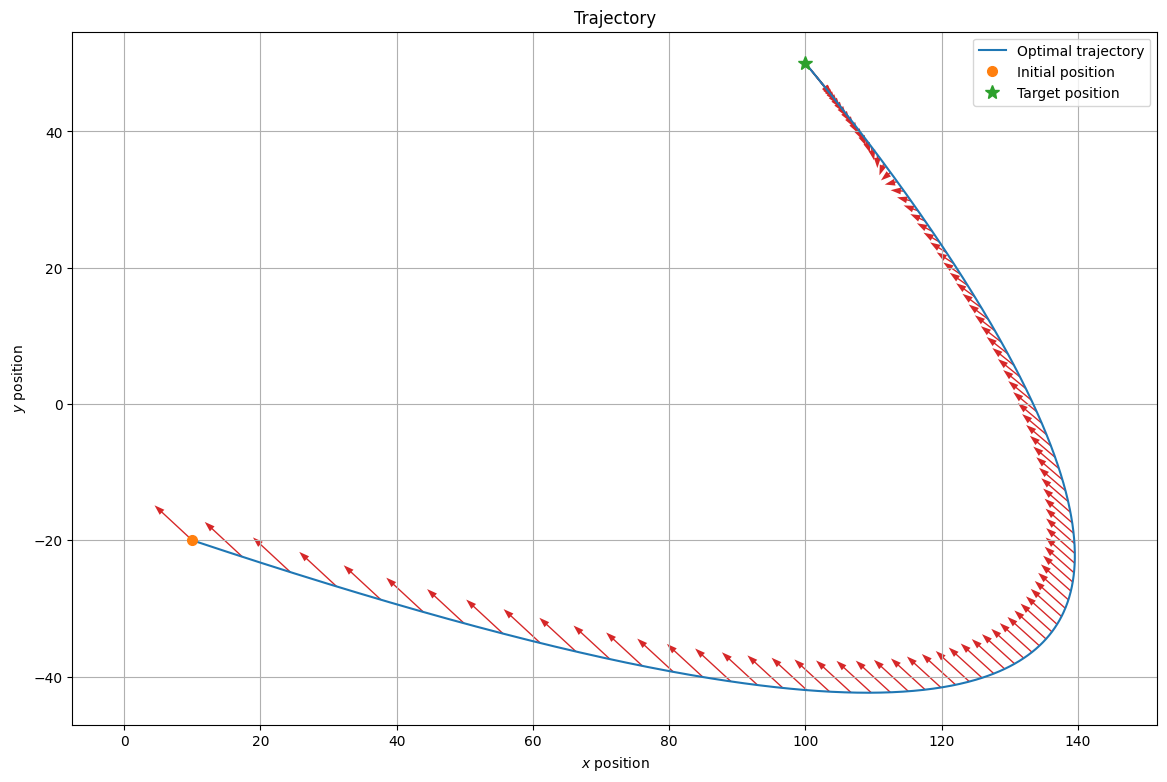

In [5]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(x[0,:],x[1,:], label='Optimal trajectory')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.title('Trajectory')
plt.legend()
for i in range(0,N-1,10):
  plt.arrow(x[0,i], x[1,i], 10*u_opt[0,i], 10*u_opt[1,i], head_width=1, width=0.2, fc='tab:red', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

<br>

For your information, $x_t$ for time $t$ other than $N$ can also be expressed similar ways with $u=(u_0, \dots, u_{N-1})$ as follows.

$$
x_1
=  Ax_0 +
{
\bmat{B & 0 & \cdots & 0 & 0}
}
\bmat{u_0 \\u_1 \\ \vdots \\ u_{N-2} \\ u_{N-1}}
$$

or

$$
x_{N-1}
=  A^{N-1}x_0 +
{
\bmat{A^{N-2}B & A^{N-3}B & \cdots & B & 0}
}
\bmat{u_0 \\u_1 \\ \vdots \\ u_{N-2} \\ u_{N-1}}
$$

or $y_t = Cx_t$ can be used for expressing other output variables at time $t$.

For example,

$$
y_{N-1} = Cx_{N-1}
=  CA^{N-1}x_0 +
{
\bmat{CA^{N-2}B & CA^{N-3}B & \cdots & CB & 0}
}
\bmat{u_0 \\u_1 \\ \vdots \\ u_{N-2} \\ u_{N-1}}
$$
with
$$
C = \bmat{0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1}
$$
can express the velocity at time $t=N-1$.

Another example,
$$
\bmat{x_{1} \\ Cx_{N-1} \\ x_{N}}
=  \bmat{A \\ CA^{N-1} \\ A^N}x_0 +
\bmat{B & 0 & \cdots & 0 & 0 \\
CA^{N-2}B & CA^{N-3}B & \cdots & CB & 0 \\
A^{N-1}B & A^{N-2}B & \cdots & AB & B}
\bmat{u_0 \\u_1 \\ \vdots \\ u_{N-2} \\ u_{N-1}}
$$
can express the position and velocity at time $t=1$, the velocity at time $t=N-1$, and the position and velocity at time $t=N$ as an affine combination of $u_0, \dots, u_{N-1}$.
